<a href="https://colab.research.google.com/github/Nastarii/Siamese-Neural-Network/blob/main/Siasmese_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir /content/Artists/
!unzip -qq /content/drive/MyDrive/Daedalus/Post_processed.zip -d /content/Artists

In [ ]:
!mkdir /content/Artists/Inference

In [ ]:
""" Dependências """

%matplotlib inline

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.utils
import torch.nn as nn
import PIL.ImageOps    
import numpy as np
import torchvision
import random
import shutil
import torch
import os

from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torch import optim
from PIL import Image

In [ ]:
""" Separação do conjunto de teste com 30 classes aleatórias """

dir = '/content/Artists/post-processed/'
classes = os.listdir(dir)
indices = random.sample(range(len(classes)), 30)
test_classes_paths = [dir + classes[i] for i in indices]

for path in test_classes_paths:

    # Move os arquivos para pasta de teste
    shutil.move(path, '/content/Artists/Inference')

In [ ]:
class SiameseNetworkDataset(Dataset):
    """ Preparação do banco de dados para a rede neural """

    def __init__(self,imageFolderDataset,transform=None) -> None:
        """ Construtor """

        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self,index) -> tuple:
        """ Acesso as amostras pelo index """

        # Seleciona uma imagem aleatória
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        # Por volta de 50% dos pares de imagens devem ser da mesma classe
        should_get_same_class = random.randint(0,1) 

        if should_get_same_class:

            while True:

                # Itera até encontrar uma imagem de mesma classe
                img1_tuple = random.choice(self.imageFolderDataset.imgs)

                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:

                # Itera até encontrar uma imagem de outra classe
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 

                if img0_tuple[1] != img1_tuple[1]:
                    break

        # Abre as imagens
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        # Faz a conversão para escala de cinza
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        # Aplica as transformações, caso sejam passadas no construtor
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        # Retorna o par de imagens, o label indicando se são da mesma classe e a localização das imagens
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32)), \
               os.path.basename(str(img0_tuple[0])), os.path.basename(str(img1_tuple[0]))
                            
    def __len__(self) -> int:
        """ Define o tamanho do banco de dados """
        
        return len(self.imageFolderDataset.imgs)

In [ ]:
def create_dataset(folder):
    """ Cria o dataset redimensionando as imagens e transformando para tensors """
    
    # Carrega o dataset
    folder_dataset = datasets.ImageFolder(root=folder)

    # Cria as transformações
    transformation = transforms.Compose([transforms.Resize((100,100)),
                                        transforms.ToTensor()])

    # Retorna o dataset com as transformações
    return SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                            transform=transformation)
    
def create_dataloader(ds, batch_size):
    """ Cria o dataloader separando os dados em batchs """
    
    return DataLoader(ds,
                      shuffle=True,
                      num_workers=2,
                      batch_size=batch_size)

In [ ]:
siamese_dataset = create_dataset("./Artists/post-processed/")

In [ ]:
def imshow(img, text=None) -> None:
    """ Cria o plot de uma imagem no formato de tensor """

    # Transforma a imagem para numpy
    npimg = img.numpy()

    # Remove os eixos do plot 
    plt.axis("off")

    # Cria o texto caso haja
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    # Plota a imagem (É necessário transpor de tensor[C, W, H] para o formato padrão[W, H, C]  )    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

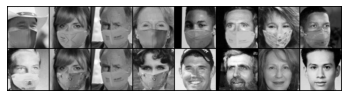

In [ ]:
def visualize_data() -> None:
    """ Cria uma visualização do banco de dados """
    
    # Cria um dataloader com batch pequeno para visualização
    vis_dataloader = create_dataloader(siamese_dataset,8)

    # Extrai um batch de exemplo
    example_batch = next(iter(vis_dataloader))

    # Concatena os pares de imagens de todo o batch
    concatenated = torch.cat((example_batch[0], example_batch[1]),0)

    # Cria a visualização do batch
    imshow(torchvision.utils.make_grid(concatenated))

visualize_data()

In [ ]:
class SiameseNetwork(nn.Module):
    """ Cria uma Siamese Network 
    
    Input: Duas imagens
    Obs: Utiliza o mesmo peso enquanto computa as duas redes neurais
    Arquitetura: DEY et al, SigNet: Convolutional Siamese Network for Writer Independent Offline Signature Verification (2017)
    Output: O Resultado do modelo para cada imagem
    """

    def __init__(self) -> None:
        super(SiameseNetwork, self).__init__()

        # Prepara os layers de convolução e max pooling com função de ativação ReLU
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Prepara os layers fully connected
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        """ Computa a rede neural uma única vez """

        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        """ Computa a siamese network para as duas entradas """
        
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

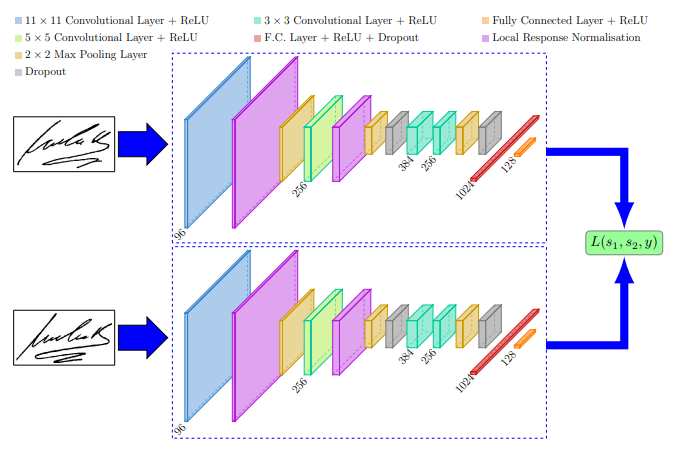

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """ Cria a Função de perda """

    def __init__(self, margin=2.0):
        """ Construtor inicializa um valor de margem """

        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        """ Computa a perda """

        # Calculo da distância euclidiana para os resultados na rede neural
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

        # Calcula a perda oara as duas outputs
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [ ]:
# Cria o train loader com o batch 64 amostras
train_dataloader = create_dataloader(siamese_dataset, 64)

In [ ]:
#Cria a rede neural
net = SiameseNetwork().cuda()

# O critério de perda mensura a diferença entre as imagens 
criterion = ContrastiveLoss()

# O otimizador permite que a rede neural aprenda e consiga atingir resultados melhores
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

In [ ]:
def show_plot(iteration,loss) -> None:
    """ Plota o resultado do treinamento """

    plt.plot(iteration,loss)
    plt.show()

In [ ]:
def train(num_epochs, show=True) -> None:
    """ Realiza o treinamento da rede neural """

    # Cria um contador que guarda o número de iterações totais
    counter = []

    # Guarda o histório de perda
    loss_history = []

    # Inicializa o número de iterações
    iteration_number= 0

    # Itera sobre as épocas
    for epoch in range(num_epochs):

        # Itera sobre os batchs
        for i, (img0, img1, label, _, _) in enumerate(train_dataloader, 0):

            # Envia as imagens e os labels para o CUDA
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

            # Zera o gradiente
            optimizer.zero_grad()

            # Computa a rede neural para o par de imagens do batch
            output1, output2 = net(img0, img1)

            # Calcula a perda com as saídas da rede neural
            loss_contrastive = criterion(output1, output2, label)

            # Calcula a backpropagation
            loss_contrastive.backward()

            # Atualiza o gradiente
            optimizer.step()

            # A cada dez batches salva o histório de perda
            if i % 10 == 0 :
                iteration_number += 10

                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
        
        print(f"Epoch #{epoch + 1}\nCurrent Loss: {loss_contrastive.item()}\n")

    if show:

        #Plota o histórico de perda
        show_plot(counter, loss_history)

Epoch #1
Current Loss: 0.8988101482391357

Epoch #2
Current Loss: 1.272896409034729

Epoch #3
Current Loss: 0.8843367695808411

Epoch #4
Current Loss: 0.8540342450141907

Epoch #5
Current Loss: 0.7313425540924072

Epoch #6
Current Loss: 0.6561614274978638

Epoch #7
Current Loss: 0.5874851942062378

Epoch #8
Current Loss: 0.8327053189277649

Epoch #9
Current Loss: 0.5421697497367859

Epoch #10
Current Loss: 0.5638270378112793

Epoch #11
Current Loss: 0.547282338142395

Epoch #12
Current Loss: 0.8374173045158386

Epoch #13
Current Loss: 0.4834502041339874

Epoch #14
Current Loss: 0.38304603099823

Epoch #15
Current Loss: 0.637850284576416



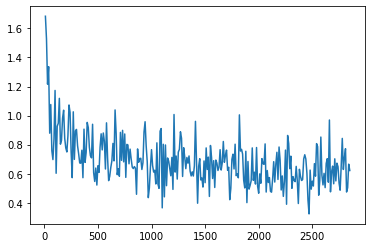

In [ ]:
# Realiza o treinamento
train(15)

In [ ]:
# Adiciona a imagem do marcelinho no banco de dados
!mkdir /content/Artists/post-processed/Marcelinho
%cp /content/drive/MyDrive/Daedalus/marcelinho_no_db.jpg /content/Artists/post-processed/Marcelinho/marcelinho_no_db.jpg

In [ ]:
# Treina o banco de dados com o marcelinho
train(3,show=False)

Epoch #1
Current Loss: 0.4346037209033966

Epoch #2
Current Loss: 0.6380520462989807

Epoch #3
Current Loss: 0.5389178395271301



In [ ]:
# Adiciona o marcelinho nos dados de inferência
!mkdir /content/Artists/Inference/Marcelinho
%cp ./drive/MyDrive/Daedalus/marcelinho_no_db.jpg ./Artists/Inference/Marcelinho/marcelinho_no_db.jpg
%cp ./drive/MyDrive/Daedalus/marcelinho_na_inferencia.jpg ./Artists/Inference/Marcelinho/marcelinho_na_inferencia.jpg

In [ ]:
# Cria um dataset para os dados de inferência
test_siamese = create_dataset("./Artists/Inference/")

# Cria um dataloader para os dados de inferência
test_dataloader = create_dataloader(test_siamese,1)

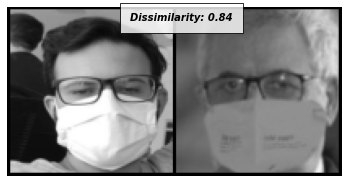

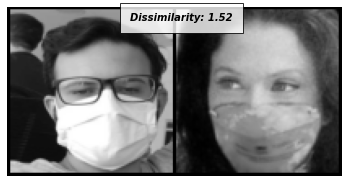

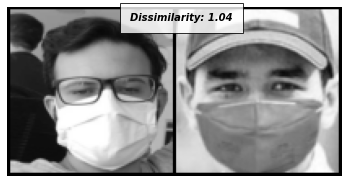

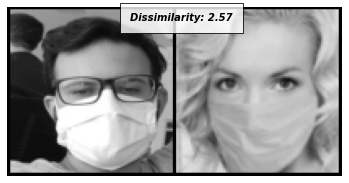

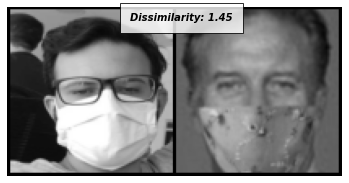

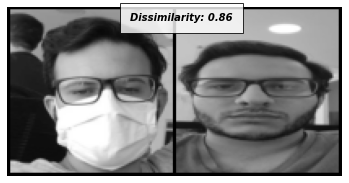

In [ ]:
# Cria uma lista de amostras de teste
x1:list = []

# Cria uma flag para indicar se já foi encontrada uma imagem de marcelinho
flag1:bool = False
flag2:bool = False

# Lista com a localização das imagens do marcelinho
filenames:list =  ['marcelinho_no_db.jpg','marcelinho_na_inferencia.jpg']

for i, (img0, img1, label, filename0, filename1) in enumerate(test_dataloader, 0):

    # Guarda a imagem caso seja de marcelinho
    if any(filename0[0] in f for f in filenames):
        
        # Se já tiver encontrado 1 guarda na outra variável
        if flag1:
            x1.append(img0)
        else:
            x0 = img0
        
        filenames.remove(filename0[0])
        
        flag1 = True

    # Se não for, adiciona imagens de teste para comparar 
    elif len(x1) < 5:
        
        x1.append(img0)

    # Guarda a outra imagem de marcelinho
    if any(filename1[0] in f for f in filenames):
        
        if flag2:
            x0 = img1
        else:    
            x1.append(img1)

        filenames.remove(filename1[0])

        flag2 = True

# Para as imagens de teste
for x in x1:

    # Concatenata com a imagem de marcelinho
    concatenated = torch.cat((x0, x), 0)
    
    # faz a inferência do par de imagens
    output1, output2 = net(x0.cuda(), x.cuda())
    
    # Calcula a distância euclidiana entre a imagem de marcelinho e a de teste
    euclidean_distance = F.pairwise_distance(output1, output2)

    #Plota os pares de imagens e o quão diferentes as amostras são (Quanto menor a distância euclidiana mais parecidos as amostras são)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')